In [1]:
import sbibm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch

In [2]:
task_name = "gaussian_mixture"

In [5]:

task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()   
    
device = "cpu"

fn = f"{task_name}"
cached_fn = f"{fn}.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [6]:
total_trials = 10

trial_sims = 10_000 # same number for both test and calibration
sims = (total_trials + 1) * trial_sims

theta = prior.sample((sims,)).to(device)
x = simulator(theta).to(device)

# very weird, but something odd happens on certain simulation runs if we generate test data at
# test time -- just generate all data (both test and calibration) ahead of time to avoid this
thetas = torch.split(theta, trial_sims)
xs = torch.split(x, trial_sims)

calibration_theta = thetas[0]
calibration_x = xs[0]

test_thetas = thetas[1:]
test_xs = xs[1:]

In [7]:
def coverage_trial(test_theta, test_x):
    test_scores = 1 / encoder.log_prob(test_theta, test_x).detach().cpu().exp().numpy()
    return [np.sum(test_scores < conformal_quantile) / trial_sims for conformal_quantile in conformal_quantiles]

In [8]:
num_coverage_pts = 20
desired_coverages = [(1 / num_coverage_pts) * k for k in range(num_coverage_pts)]

cal_scores = 1 / encoder.log_prob(calibration_theta, calibration_x).detach().cpu().exp().numpy()
conformal_quantiles = np.array([np.quantile(cal_scores, q = coverage) for coverage in desired_coverages])

In [9]:
def coverage_trial(test_theta, test_x):
    test_scores = 1 / encoder.log_prob(test_theta, test_x).detach().cpu().exp().numpy()
    return [np.sum(test_scores < conformal_quantile) / trial_sims for conformal_quantile in conformal_quantiles]

In [10]:
def var_coverage_trial(test_theta, test_x):
    variational_dist_samples = 100
    empirical_theta_dist = encoder.sample((variational_dist_samples), test_x)
    sample_x = np.transpose(np.tile(test_x, (variational_dist_samples,1,1)), (1, 0, 2))

    flat_empirical_theta_dist = empirical_theta_dist.reshape(-1, empirical_theta_dist.shape[-1])
    flat_sample_x = sample_x.reshape(-1, empirical_theta_dist.shape[-1])
    var_probs = encoder.log_prob(flat_empirical_theta_dist, flat_sample_x).detach()
    var_log_probs = var_probs.reshape((trial_sims, -1))
    unnorm_probabilities = var_log_probs.cpu().exp().numpy()

    var_quantiles = []
    for k, desired_coverage in enumerate(desired_coverages):
        var_quantiles.append(np.quantile(unnorm_probabilities, q = 1 - desired_coverage, method="inverted_cdf", axis=1))
    var_quantiles = np.transpose(np.array(var_quantiles), (1, 0))

    predicted_prob = encoder.log_prob(test_theta, test_x).cpu().exp().detach().numpy()
    tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
    return np.sum(tiled_predicted_probs > var_quantiles, axis=0) / trial_sims

In [11]:
dfs = []
for i in range(total_trials):
    df = pd.DataFrame(columns=["confidence", "coverages"])
    df["confidence"] = desired_coverages
    df["coverages"] = coverage_trial(test_thetas[i], test_xs[i])
    df["var_coverages"] = var_coverage_trial(test_thetas[i], test_xs[i])
    dfs.append(df)
df = pd.concat(dfs)   

/home/yppatel/anaconda3/envs/chig/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  outputs, _ = torch.triangular_solve(


<Axes: xlabel='confidence', ylabel='confidence'>

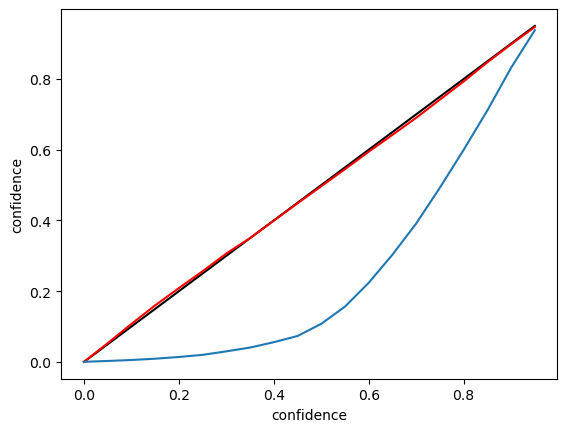

In [12]:
sns.lineplot(data=df, x="confidence", y="confidence", color="black", linestyle="-")
sns.lineplot(data=df, x="confidence", y="coverages", color="red", linestyle="-")
sns.lineplot(data=df, x="confidence", y="var_coverages")

In [20]:
test_xs[0].shape

torch.Size([10000, 2])

In [22]:
variational_dist_samples = 10
encoder.to(device)
empirical_theta_dist = encoder.sample((variational_dist_samples), test_xs[0])
sample_x = np.transpose(np.tile(test_xs[0], (variational_dist_samples,1,1)), (1, 0, 2))

flat_empirical_theta_dist = empirical_theta_dist.reshape(-1, empirical_theta_dist.shape[-1])
flat_sample_x = sample_x.reshape(-1, empirical_theta_dist.shape[-1])
var_probs = encoder.log_prob(flat_empirical_theta_dist, flat_sample_x).detach()
var_log_probs = var_probs.reshape((10_000, -1))
unnorm_probabilities = var_log_probs.cpu().exp().numpy()

var_quantiles = []
for k, desired_coverage in enumerate(desired_coverages):
    var_quantiles.append(np.quantile(unnorm_probabilities, q = 1 - desired_coverage, method="inverted_cdf", axis=1))
var_quantiles = np.transpose(np.array(var_quantiles), (1, 0))

predicted_prob = encoder.log_prob(test_xs[0], test_thetas[0]).cpu().exp().detach().numpy()
tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
variational_cov = np.sum(tiled_predicted_probs > var_quantiles, axis=0)

torch.Size([100000, 2])
(100000, 2)


In [37]:
var_log_probs = var_probs.reshape((10_000, -1))
unnorm_probabilities = var_log_probs.cpu().exp().numpy()

var_quantiles = []
for k, desired_coverage in enumerate(desired_coverages):
    var_quantiles.append(np.quantile(unnorm_probabilities, q = 1 - desired_coverage, method="inverted_cdf", axis=1))
var_quantiles = np.transpose(np.array(var_quantiles), (1, 0))

predicted_prob = encoder.log_prob(test_xs[0], test_thetas[0]).cpu().exp().detach().numpy()
tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
variational_cov = np.sum(tiled_predicted_probs > var_quantiles, axis=0)

In [44]:
predicted_prob = encoder.log_prob(test_xs[0], test_thetas[0]).cpu().exp().detach().numpy()
tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
variational_cov = np.sum(tiled_predicted_probs > var_quantiles, axis=0)

In [56]:
tiled_predicted_probs = np.tile(predicted_prob.reshape(-1,1), (1,20))
variational_cov = np.sum(tiled_predicted_probs > var_quantiles, axis=0)

In [63]:
variational_cov = np.sum(tiled_predicted_probs > var_quantiles, axis=0)

In [275]:
encoder.to(device)
variational_coverages = np.zeros(num_coverage_pts)
for test_theta, test_x in zip(test_thetas, test_xs):
    for test_theta_pt, test_x_pt in zip(test_theta, test_x):
        variational_set_size = 10

        empirical_theta_dist = encoder.sample(variational_set_size, test_x_pt.view(1,-1)).detach().numpy()[0]
        predicted_lps = encoder.log_prob(empirical_theta_dist, np.tile(test_x_pt.view(1,-1), (variational_set_size,1))).detach()
        unnorm_probabilities = predicted_lps.cpu().exp().numpy()

        var_quantiles = np.zeros(len(desired_coverages))
        for k, desired_coverage in enumerate(desired_coverages):
            var_quantiles[k] = np.quantile(unnorm_probabilities, q = 1 - desired_coverage, method="inverted_cdf")
        predicted_prob = encoder.log_prob(test_theta_pt.view(1,-1), test_x_pt.view(1,-1)).detach().cpu().exp().numpy()
        variational_coverages += predicted_prob > var_quantiles
    break

In [279]:
variational_coverages / 10_000

array([0.0067, 0.0067, 0.0161, 0.0161, 0.032 , 0.032 , 0.0606, 0.0606,
       0.1114, 0.1114, 0.1915, 0.1915, 0.3074, 0.3074, 0.4657, 0.4657,
       0.6451, 0.6451, 0.838 , 0.838 ])

<Axes: >

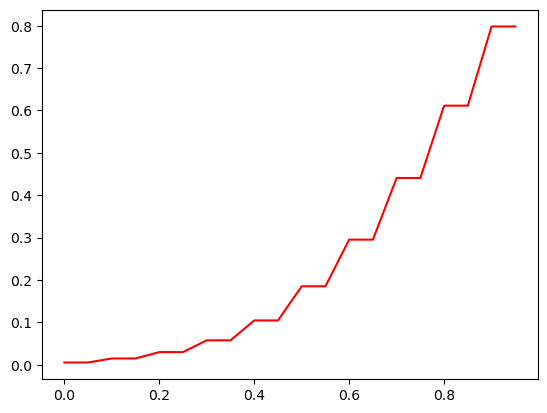

In [65]:
sns.lineplot(x=desired_coverages, y=variational_cov / 10_000, color="red")